
📦 Two-Phase FCM-Based Sensitivity Simulation Framework (Pseudocode with Explanation)



# ============================================
# Phase 1 – Scenario Initialization (Input Design)
# ============================================

1. Let d be the number of input variables (BSMs).
2. Generate N input scenarios using Latin Hypercube Sampling (LHS):
    - Each scenario is a d-dimensional vector in the range [0, 1].

3. For each scenario:
    a. Assign fixed random values to:
        - Random root nodes → sampled from Uniform[−1, +1]
        - Intermediate nodes → sampled from Uniform[−1, +1]

4. Store the full scenario vectors (BSM inputs + random + intermediate)
   for later use in simulation.

# ============================================
# Phase 2 – Perturbation-Based Simulation
# ============================================

For each scenario from 1 to N:
    1. Load the scenario vector:
        - BSM input values
        - Random and intermediate node values (held constant)

    2. For each BSM_i (i = 1 to d):
        a. Define P perturbation values in [0, 1] (e.g., P = 5)

        b. For each perturbation value v in the list:
            i. Clone the base BSM input vector
            ii. Replace the value of BSM_i with v

            iii. Initialize the full FCM state:
                - Fuzzify BSM inputs (triangular membership)
                - Assign random and intermediate nodes
                - Set output nodes to neutral fuzzy values

            iv. Run the FCM for T iterations (e.g., T = 10):
                For each time step t:
                    For each non-root, non-random node:
                        - Aggregate weighted inputs from predecessors
                        - Normalize the sum of influences
                        - Apply the nonlinear activation function (e.g., tanh)

            v. After the final iteration:
                - Defuzzify output nodes
                - Compute average output activation across all output nodes
                - Record result: (Scenario, BSM_i, Perturbation_v, Output)

# ============================================
# Post-Processing – Sensitivity Metric Computation
# ============================================

After all simulations:
    For each BSM_i:
        - Collect all output values across N scenarios and P perturbations
        - Compute the following sensitivity indicators:
            • Range (max - min)
            • MAE (Mean Absolute Effect)
            • ATS (Average Total Sensitivity)
            • TKSC (Top-K Sensitivity Concentration)
            • NSE (Normalized Sensitivity Entropy)
            • PSI (Proportion of Significant Inputs)


In [1]:
!pip install pyDOE

  Preparing metadata (setup.py) ... done
  Created wheel for pyDOE: filename=pyDOE-0.3.8-py3-none-any.whl size=18170 sha256=506a2b6f0e31364c328f6e000ba466a1cfe33defa0353277ecd5f18dab46e385
  Stored in directory: /root/.cache/pip/wheels/84/20/8c/8bd43ba42b0b6d39ace1219d6da1576e0dac81b12265c4762e
Successfully built pyDOE


In [2]:
import networkx as nx

# Load the graph from the file
all_network = nx.read_graphml('/content/all_network.graphml')
print("Graph has been loaded from all_network.graphml")


Graph has been loaded from all_network.graphml


In [3]:
import pandas as pd
import numpy as np
import os
import networkx as nx
import unicodedata
import re

# ---------- Utility Functions ----------
def clean_node_name(name):
    name = str(name).strip().lower()
    name = unicodedata.normalize("NFKD", name)
    name = re.sub(r'[\u200b-\u200f\u202a-\u202e\u00a0]', '', name)
    return name

def defuzzify(fuzzy_vector):
    weights = [-1.0, -0.5, 0.0, 0.5, 1.0]
    return sum(f * w for f, w in zip(fuzzy_vector, weights)) / sum(fuzzy_vector)

def nonlinear_transition(weighted_sum, total_weight, alpha=1.5):
    if total_weight == 0:
        return 0.0
    return np.tanh(alpha * (weighted_sum / total_weight))

def triangular_membership(x, a, b, c):
    if x < a or x > c:
        return 0.0
    elif x == b:
        return 1.0
    elif x < b:
        return (x - a) / (b - a) if (b - a) != 0 else 0.0
    else:
        return (c - x) / (c - b) if (c - b) != 0 else 0.0

def fuzzify_bsp_input(value):
    x = float(value)
    return [
        max(0, 1 - 4 * x),
        max(0, 1 - abs(4 * x - 1)),
        max(0, 1 - abs(4 * x - 2)),
        max(0, 1 - abs(4 * x - 3)),
        max(0, 4 * x - 3) if x >= 0.75 else 0
    ]

def normalize_weight(w, original_min=0, original_max=5, target_min=0, target_max=1):
    if w is None:
        return 0
    w = float(w)
    return ((w - original_min) / (original_max - original_min)) * (target_max - target_min) + target_min

# ---------- Graph and State ----------
def graph_to_fcm(g, weight_property=None, normalize=True):
    num_vertices = len(g.nodes())
    fcm_matrix = np.zeros((num_vertices, num_vertices))
    node_index = {node: idx for idx, node in enumerate(g.nodes())}
    for source, target, data in g.edges(data=True):
        source_idx = node_index[source]
        target_idx = node_index[target]
        weight = data.get(weight_property, 1.0)
        if normalize:
            weight = normalize_weight(float(weight))
        fcm_matrix[source_idx, target_idx] = weight
    return fcm_matrix, node_index

def initialize_fcm_state(graph, node_index, scenario_row):
    init_state = {}
    random_nodes = []
    root_nodes = []
    output_nodes = []

    for node, data in graph.nodes(data=True):
        i = node_index[node]
        name = clean_node_name(data.get('name', str(node)))
        label = clean_node_name(data.get('label', str(node)))
        is_random = "random" in name
        is_behavior = re.search(r"_behavior_\d+$", label)
        is_root = graph.in_degree(node) == 0

        if is_random:
            random_nodes.append(i)
            init_state[i] = np.random.uniform(-1.0, 1.0)
        elif is_behavior:
            output_nodes.append(i)
            init_state[i] = {
                'Low': triangular_membership(0, -1.0, -1.0, 0.0),
                'Medium': triangular_membership(0, -1.0, 0.0, 1.0),
                'High': triangular_membership(0, 0.0, 1.0, 1.0)
            }
        else:
            if name in scenario_row:
                init_state[i] = fuzzify_bsp_input(scenario_row[name])
            else:
                init_state[i] = 0.0

        if is_root:
            root_nodes.append(i)

    return init_state, random_nodes, root_nodes, output_nodes

def simulate_fcm(fcm_matrix, init_state, root_nodes, random_nodes, output_nodes, iterations=10):
    num_nodes = fcm_matrix.shape[0]
    current_state = init_state.copy()

    for _ in range(iterations):
        next_state = current_state.copy()
        for i in range(num_nodes):
            if i in root_nodes or i in random_nodes:
                continue
            weighted_sum, total_weight = 0.0, 0.0
            for j in range(num_nodes):
                w = fcm_matrix[j, i]
                if w == 0: continue
                val = current_state[j]
                if isinstance(val, dict): val = defuzzify(list(val.values()))
                elif isinstance(val, list): val = defuzzify(val)
                weighted_sum += val * w
                total_weight += abs(w)
            next_state[i] = nonlinear_transition(weighted_sum, total_weight)
        current_state = next_state

    outputs = []
    for i in output_nodes:
        val = current_state[i]
        if isinstance(val, dict): outputs.append(defuzzify(list(val.values())))
        else: outputs.append(val)
    return np.mean(outputs)

# ---------- Parameters ----------
scenario_file = "bsp_input_scenarios.csv"
graph_file = "all_network.graphml"
result_file = "sensitivity_output_results.csv"
perturbations_per_node = 5
iterations = 6
output_range = (0.0, 1.0)

# ---------- Load Inputs ----------
g = nx.read_graphml(graph_file)
df_scenarios = pd.read_csv(scenario_file)
df_scenarios.columns = [clean_node_name(c) for c in df_scenarios.columns]
fcm_matrix, node_index = graph_to_fcm(g, weight_property="weight", normalize=True)
index_to_name = {node_index[node]: clean_node_name(g.nodes[node].get("name", str(node))) for node in g.nodes()}

# ---------- Determine BSP Nodes ----------
sample_row = df_scenarios.iloc[0]
init_tmp, rand_tmp, root_tmp, _ = initialize_fcm_state(g, node_index, sample_row)
bsp_nodes = [i for i in root_tmp if i not in rand_tmp]

# ---------- Load Results ----------
expected_columns = ["scenario", "bsp_node_index", "bsp_node_name", "perturb_id", "output"]
if os.path.exists(result_file):
    df_results = pd.read_csv(result_file)
    if not all(col in df_results.columns for col in expected_columns):
        df_results = pd.DataFrame(columns=expected_columns)
else:
    df_results = pd.DataFrame(columns=expected_columns)

done_keys = set(zip(df_results["scenario"], df_results["bsp_node_index"], df_results["perturb_id"]))
step = 0
total_steps = len(df_scenarios) * len(bsp_nodes) * perturbations_per_node

# ---------- Simulation Loop ----------
for s in range(len(df_scenarios)):
    row = df_scenarios.iloc[s]
    init_state, rand_nodes, root_nodes, out_nodes = initialize_fcm_state(g, node_index, row)

    for b_idx, bsp in enumerate(bsp_nodes):
        for p in range(perturbations_per_node):
            key = (s, bsp, p)
            step += 1
            if key in done_keys:
                continue

            perturbed_val = np.random.uniform(*output_range)
            init_state_perturbed = init_state.copy()
            init_state_perturbed[bsp] = fuzzify_bsp_input(perturbed_val)
            output_val = simulate_fcm(fcm_matrix, init_state_perturbed, root_nodes, rand_nodes, out_nodes, iterations)
            bsp_name = index_to_name[bsp]

            df_results.loc[len(df_results)] = {
                "scenario": s,
                "bsp_node_index": bsp,
                "bsp_node_name": bsp_name,
                "perturb_id": p,
                "output": output_val
            }

            percent_done = 100 * step / total_steps
            print(f"Scenario {s+1} | BSP {b_idx+1}/{len(bsp_nodes)} | Perturb {p+1}/{perturbations_per_node} | Progress: {percent_done:.1f}%")

            if step % 10 == 0:
                df_results.to_csv(result_file, index=False)

df_results.to_csv(result_file, index=False)
print("✅ Simulation completed and saved.")


Streaming output truncated to the last 5000 lines.
Scenario 486 | BSP 50/70 | Perturb 3/5 | Progress: 97.1%
Scenario 486 | BSP 50/70 | Perturb 4/5 | Progress: 97.1%
Scenario 486 | BSP 50/70 | Perturb 5/5 | Progress: 97.1%
Scenario 486 | BSP 51/70 | Perturb 1/5 | Progress: 97.1%
Scenario 486 | BSP 51/70 | Perturb 2/5 | Progress: 97.1%
Scenario 486 | BSP 51/70 | Perturb 3/5 | Progress: 97.1%
Scenario 486 | BSP 51/70 | Perturb 4/5 | Progress: 97.1%
Scenario 486 | BSP 51/70 | Perturb 5/5 | Progress: 97.1%
Scenario 486 | BSP 52/70 | Perturb 1/5 | Progress: 97.1%
Scenario 486 | BSP 52/70 | Perturb 2/5 | Progress: 97.1%
Scenario 486 | BSP 52/70 | Perturb 3/5 | Progress: 97.1%
Scenario 486 | BSP 52/70 | Perturb 4/5 | Progress: 97.1%
Scenario 486 | BSP 52/70 | Perturb 5/5 | Progress: 97.1%
Scenario 486 | BSP 53/70 | Perturb 1/5 | Progress: 97.1%
Scenario 486 | BSP 53/70 | Perturb 2/5 | Progress: 97.1%
Scenario 486 | BSP 53/70 | Perturb 3/5 | Progress: 97.2%
Scenario 486 | BSP 53/70 | Perturb 4/


📊 Summary of Sensitivity Indicators:


,BSM,MeanSensitivity,StdSensitivity,MAE
57,safety_resource_allocation,0.0525,0.0146,0.0022
64,senior_managers_safety_training,0.0396,0.0108,0.0021
21,operational_supervisors_empowerment_for_effect...,0.0349,0.0094,0.0026
5,contractor_safety_management,0.0342,0.0146,0.0013
8,decision_making_and_emergency_response_under_s...,0.0341,0.0094,0.0023
...,...,...,...,...
41,safety_leadership_accountability,0.0075,0.0020,0.0002
44,safety_lesson_documentation_and_sharing,0.0075,0.0020,0.0003
28,safety_communication_system,0.0074,0.0021,0.0003
43,safety_learning_and_knowledge_management_systems,0.0063,0.0018,0.0002



🔍 Global Sensitivity Metrics:
✅ Average Total Sensitivity (ATS): 0.0198
✅ Top-10 Sensitivity Concentration (TKSC): 0.2545
✅ Normalized Sensitivity Entropy (NSE): 0.9783
✅ Proportion of Significant Inputs (PSI): 0.5000


<ipython-input-11-fc9e46f21d64>:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='MeanSensitivity', y='BSM', data=final_summary, palette="viridis")


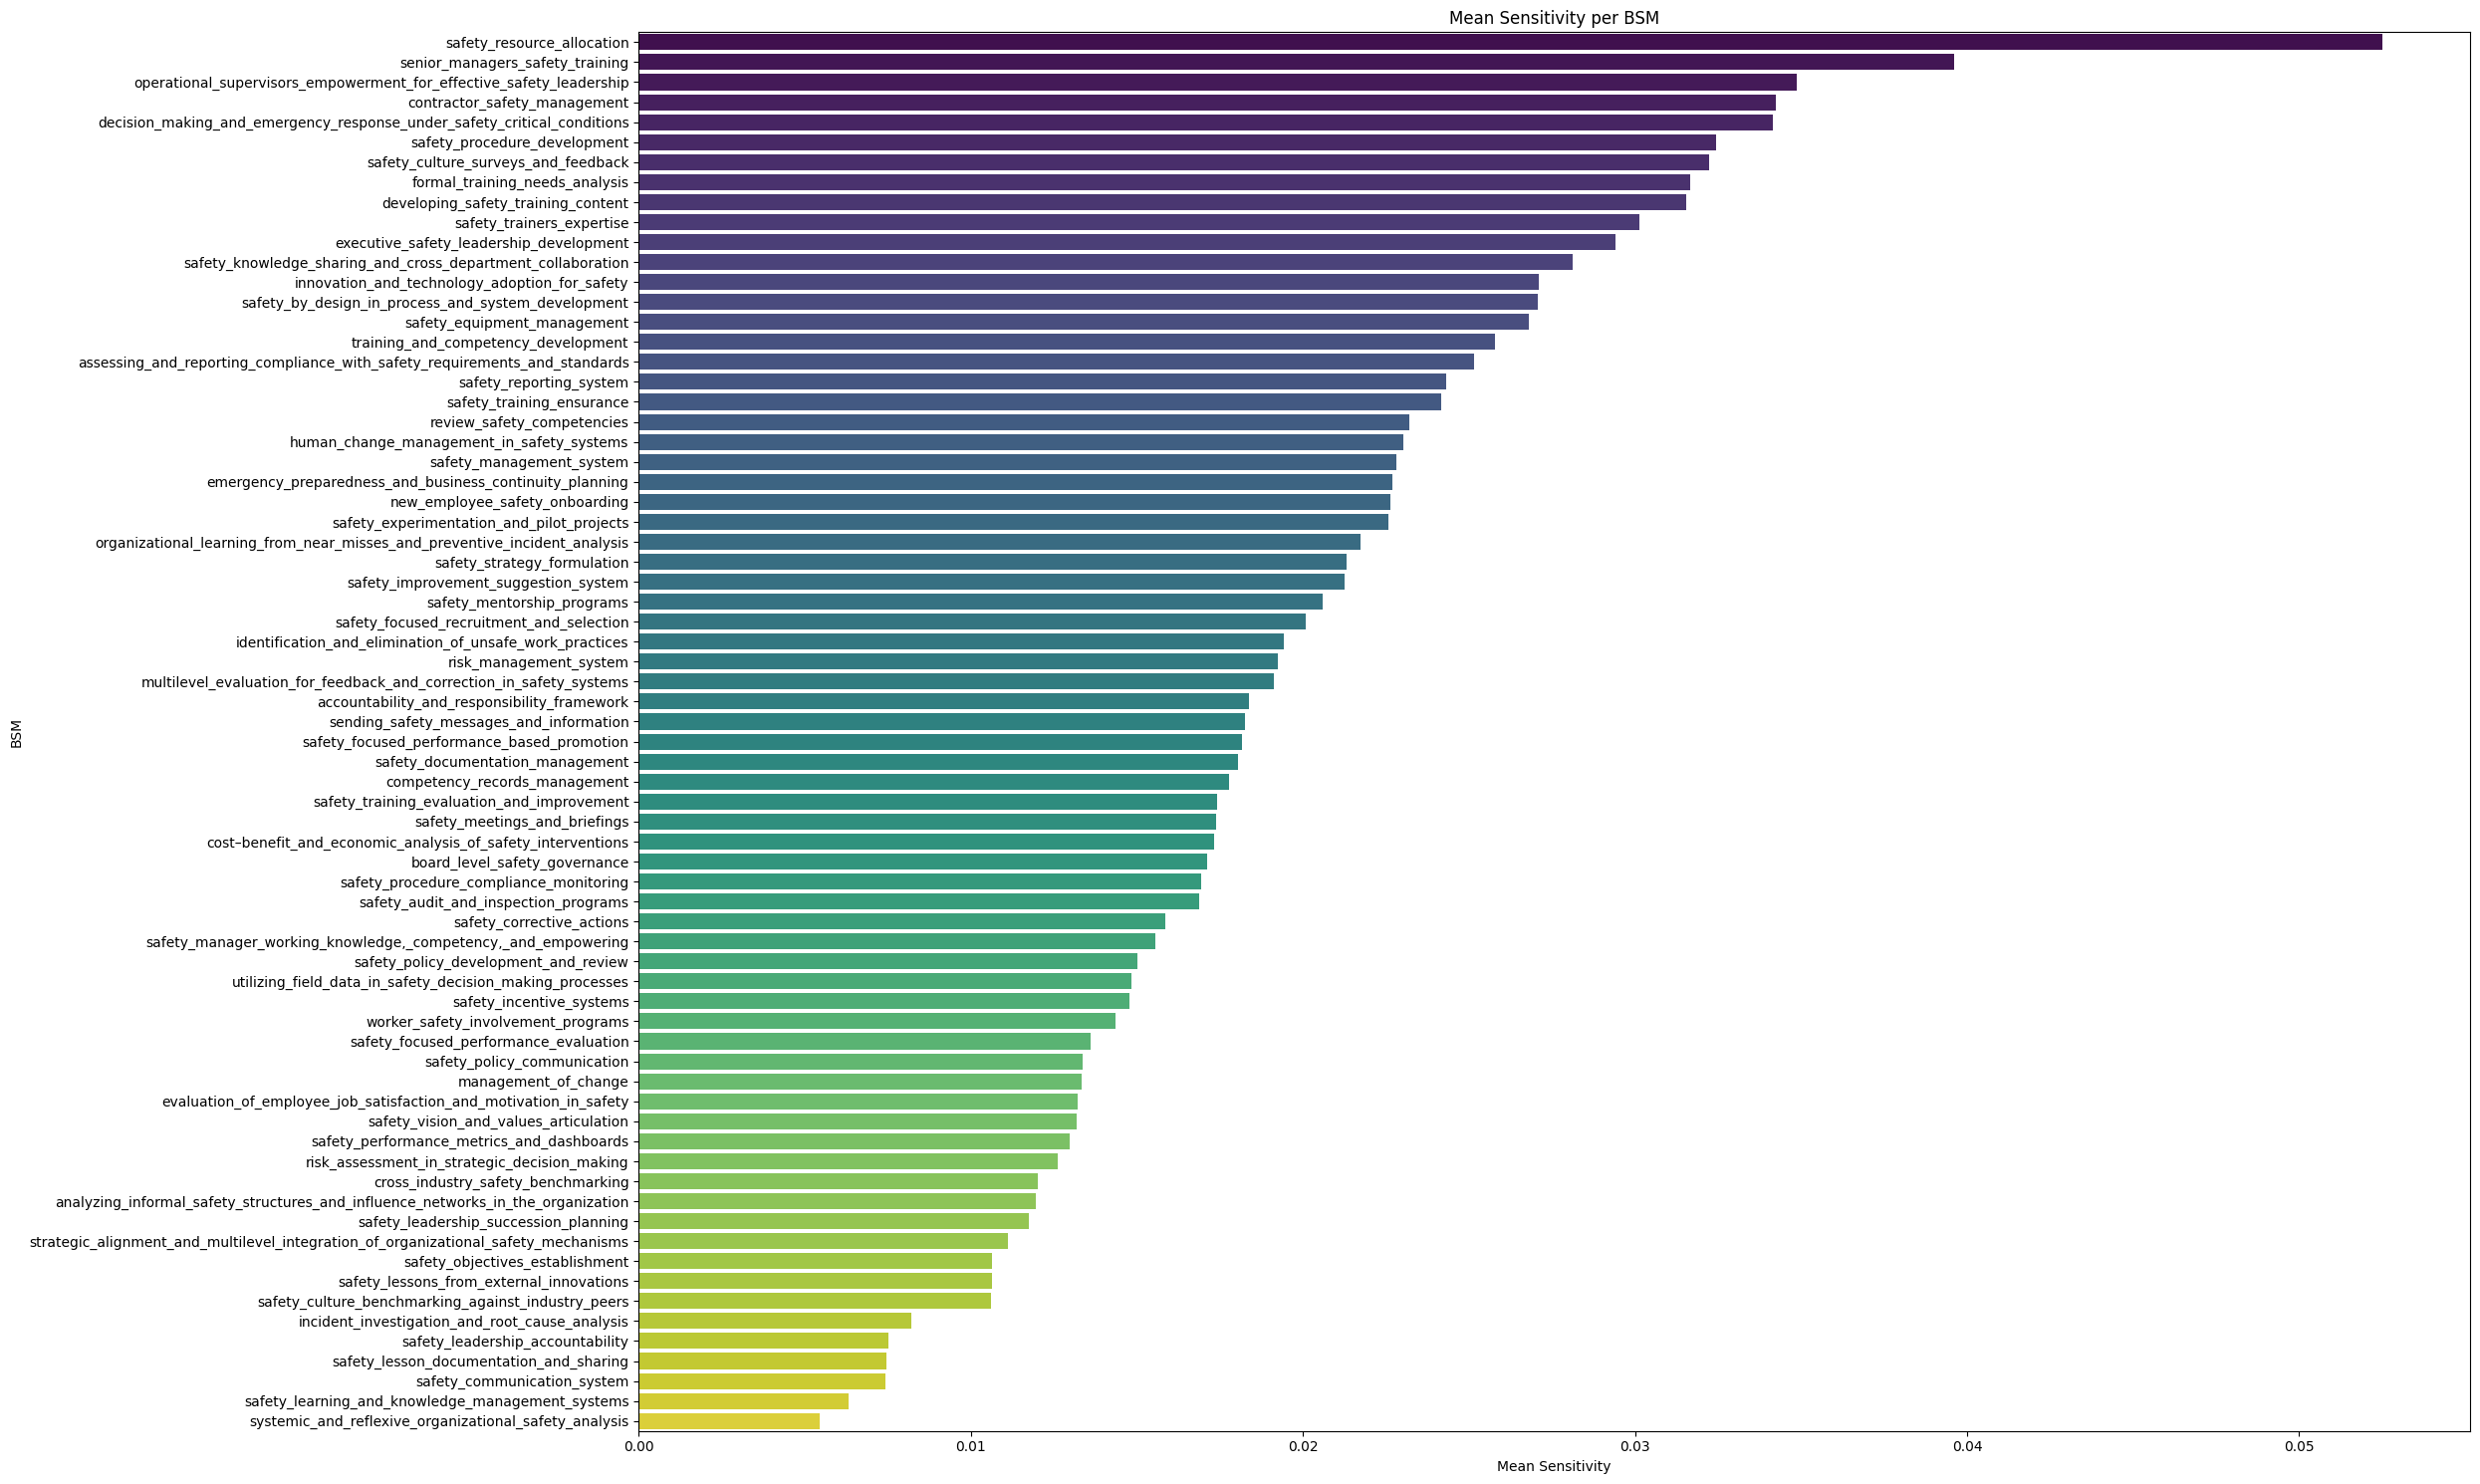

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

# Load simulation results
df = pd.read_csv("sensitivity_output_results.csv")

# Step 1: Sensitivity per (Scenario, BSM)
sensitivity_by_bsm = df.groupby(['scenario', 'bsp_node_name'])['output'].agg(lambda x: np.max(x) - np.min(x)).reset_index()
sensitivity_by_bsm.rename(columns={'output': 'Sensitivity'}, inplace=True)

# Step 2: Aggregate per BSM
bsm_agg = sensitivity_by_bsm.groupby('bsp_node_name')['Sensitivity'].agg(['mean', 'std']).reset_index()
bsm_agg.columns = ['BSM', 'MeanSensitivity', 'StdSensitivity']

# Step 3: Global Sensitivity Metrics
ATS = bsm_agg['MeanSensitivity'].mean()
K = 10
TKSC = bsm_agg.sort_values('MeanSensitivity', ascending=False).head(K)['MeanSensitivity'].sum() / bsm_agg['MeanSensitivity'].sum()
p = bsm_agg['MeanSensitivity'] / bsm_agg['MeanSensitivity'].sum()
NSE = -np.sum(p * np.log(p)) / np.log(len(p))
threshold = bsm_agg['MeanSensitivity'].median()
PSI = (bsm_agg['MeanSensitivity'] > threshold).sum() / len(bsm_agg)


# Merge for full table
final_summary = final_summary.sort_values("MeanSensitivity", ascending=False)

# Show table
print("\n📊 Summary of Sensitivity Indicators:")
display(final_summary.round(4))

# Step 5: Show All Metrics
print("\n🔍 Global Sensitivity Metrics:")
print(f"✅ Average Total Sensitivity (ATS): {ATS:.4f}")
print(f"✅ Top-{K} Sensitivity Concentration (TKSC): {TKSC:.4f}")
print(f"✅ Normalized Sensitivity Entropy (NSE): {NSE:.4f}")
print(f"✅ Proportion of Significant Inputs (PSI): {PSI:.4f}")


# Step 6: Plots
plt.figure(figsize=(25, 15))
sns.barplot(x='MeanSensitivity', y='BSM', data=final_summary, palette="viridis")
plt.title("Mean Sensitivity per BSM")
plt.xlabel("Mean Sensitivity")
plt.ylabel("BSM")
plt.tight_layout()
plt.show()



<ipython-input-8-1e45617036a4>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='bsp_node_name', y='output', order=bsp_order, palette="pastel")
<ipython-input-8-1e45617036a4>:21: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


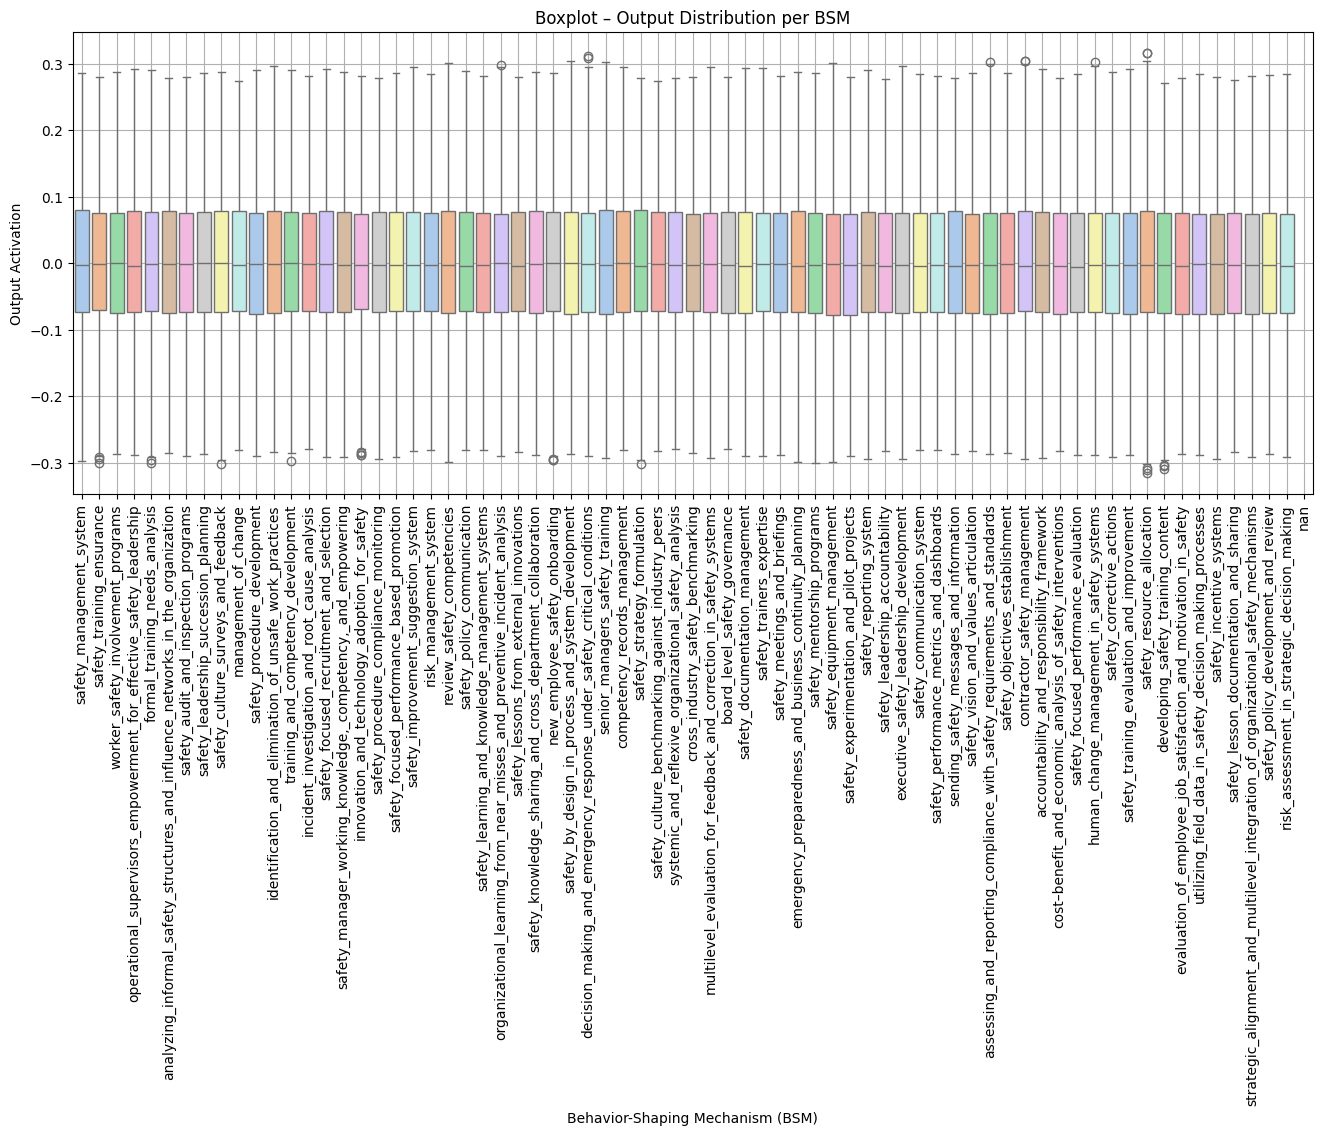

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load result file
df = pd.read_csv("sensitivity_output_results.csv")

# Prepare data
# Ensure columns: 'BSM', 'PerturbationIndex', 'OutputValue'
# Group by BSM → collect OutputValue for all perturbations
bsp_order = df['bsp_node_name'].unique().tolist()

# Plot
plt.figure(figsize=(16, 6))
sns.boxplot(data=df, x='bsp_node_name', y='output', order=bsp_order, palette="pastel")
plt.xticks(rotation=90)
plt.title("Boxplot – Output Distribution per BSM")
plt.xlabel("Behavior-Shaping Mechanism (BSM)")
plt.ylabel("Output Activation")
plt.grid(True)
plt.tight_layout()
plt.savefig("boxplot_per_bsm.png")
plt.show()
